# 可选实验 - Softmax 函数
在这个实验中，我们将探讨 softmax 函数。这个函数在解决多类分类问题时，既用于 softmax 回归，也用于神经网络中。

![图片](./images/C2_W2_Softmax_Header.PNG)

In [72]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('./deeplearning.mplstyle')
import tensorflow as tf
from tensorflow import keras
from  keras.models import Sequential
from  keras.layers import Dense
from IPython.display import display, Markdown, Latex
from sklearn.datasets import make_blobs
%matplotlib widget
from matplotlib.widgets import Slider
from lab_utils_common import dlc
from lab_utils_softmax import plt_softmax
import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)
tf.autograph.set_verbosity(0)

**注意：** 通常，在这门课程中，笔记本使用从0开始计数，以N-1结束的约定，$\sum_{i=0}^{N-1}$，而讲座以1开始计数，以N结束，$\sum_{i=1}^{N}$。这是因为代码通常从0开始迭代，而在讲座中，从1到N的计数可以产生更清晰、更简洁的方程。这个笔记本比实验室通常更多方程，因此会打破常规，计数从1到N。

## Softmax 函数
在 softmax 回归和具有 Softmax 输出的神经网络中，会生成 N 个输出，并选择一个输出作为预测的类别。在这两种情况下，通过一个线性函数生成一个向量 $\mathbf{z}$，然后将 softmax 函数应用于该向量。softmax 函数将 $\mathbf{z}$ 转换为如下所述的概率分布。应用 softmax 后，每个输出都会在 0 到 1 之间，并且这些输出加起来等于 1，因此它们可以被解释为概率。较大的输入对应于较大的输出概率。

![图片](./images/C2_W2_SoftmaxReg_NN.png)

Softmax 函数可以写成如下形式：
$$a_j = \frac{e^{z_j}}{ \sum_{k=1}^{N}{e^{z_k} }} \tag{1}$$
输出 $\mathbf{a}$ 是一个长度为 N 的向量，因此对于 softmax 回归，也可以写成如下形式：
\begin{align}
\mathbf{a}(x) =
\begin{bmatrix}
P(y = 1 | \mathbf{x}; \mathbf{w},b) \\
\vdots \\
P(y = N | \mathbf{x}; \mathbf{w},b)
\end{bmatrix}
=
\frac{1}{ \sum_{k=1}^{N}{e^{z_k} }}
\begin{bmatrix}
e^{z_1} \\
\vdots \\
e^{z_{N}} \\
\end{bmatrix} \tag{2}
\end{align}

这显示输出是一个概率向量。第一个条目是在给定输入 $\mathbf{x}$ 和参数 $\mathbf{w}$ 和 $\mathbf{b}$ 的情况下，输入属于第一类别的概率。  
让我们创建一个 NumPy 实现：

In [73]:
def my_softmax(z):
    ez = np.exp(z)              #element-wise exponenial
    sm = ez/np.sum(ez)
    return(sm)

在下面，使用滑块来变化 `z` 输入的值。

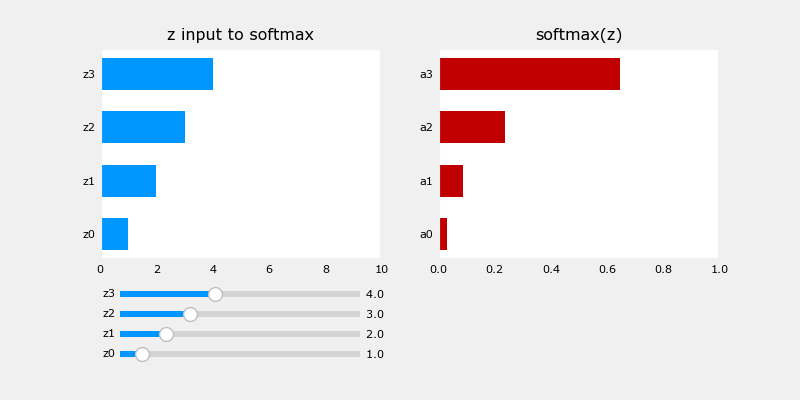

In [74]:
plt.close("all")
plt_softmax(my_softmax)

当您在上面变化 `z` 的值时，有一些要注意的事项：
* softmax 分子中的指数放大了值之间的小差异
* 输出值相加为一
* softmax 跨越所有输出。例如，`z0` 的变化将改变 `a0`-`a3` 的值。与其他激活函数（如 ReLu 或 Sigmoid）相比，它们具有单一输入和单一输出。

## Cost
<center> <img  src="./images/C2_W2_SoftMaxCost.png" width="400" />    <center/>

与 Softmax 相关的损失函数，交叉熵损失，如下所示：
\begin{equation}
  L(\mathbf{a},y)=\begin{cases}
    -\log(a_1), & \text{如果 $y=1$}。\\
        &\vdots\\
     -\log(a_N), & \text{如果 $y=N$}
  \end{cases} \tag{3}
\end{equation}

其中 $y$ 是此示例的目标类别，$\mathbf{a}$ 是 softmax 函数的输出。特别地，$\mathbf{a}$ 中的值是归一化的概率。
> **回顾：** 在本课程中，Loss 用于单个示例，而 Cost 用于所有示例。

请注意，在上面的公式（3）中，只有与目标对应的行会对损失有贡献，其他行的损失为零。为了编写成本方程，我们需要一个“指示函数”，当索引与目标匹配时为1，否则为零。
$$\mathbf{1}\{y == n\} = =\begin{cases}
    1, & \text{如果 $y==n$}。\\
    0, & \text{否则}。
  \end{cases}$$
现在成本是：
\begin{align}
J(\mathbf{w},b) = - \left[ \sum_{i=1}^{m} \sum_{j=1}^{N}  1\left\{y^{(i)} == j\right\} \log \frac{e^{z^{(i)}_j}}{\sum_{k=1}^N e^{z^{(i)}_k} }\right] \tag{4}
\end{align}

其中 $m$ 是示例数，$N$ 是输出数。这是所有损失的平均值。

## Tensorflow
本实验室将讨论在Tensorflow中实现softmax和交叉熵损失的两种方法，一种是“显而易见”的方法，另一种是“首选”的方法。前者最直接，而后者在数值上更稳定。

让我们首先创建一个用于训练多类分类模型的数据集。

In [75]:
# make  dataset for example
centers = [[-5, 2], [-2, -2], [1, 2], [5, -2]]
X_train, y_train = make_blobs(n_samples=2000, centers=centers, cluster_std=1.0,random_state=30)

### The *Obvious* organization

下面的模型在最后一个 Dense 层中使用 softmax 作为激活函数。损失函数在 `compile` 指令中单独指定。

损失函数使用 `SparseCategoricalCrossentropy`。这个损失函数与上面（3）中描述的一致。在这个模型中，softmax 在最后一层进行。损失函数接受 softmax 输出，这是一个概率向量。

In [76]:
model = Sequential(
    [ 
        Dense(25, activation = 'relu'),
        Dense(15, activation = 'relu'),
        Dense(4, activation = 'softmax')    # < softmax activation here
    ]
)
model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(0.001),
)

model.fit(
    X_train,y_train,
    epochs=10
)
        

Epoch 1/10
63/63 [==============================] - 1s 1ms/step - loss: 0.9319
Epoch 2/10
63/63 [==============================] - 0s 1ms/step - loss: 0.3470
Epoch 3/10
63/63 [==============================] - 0s 1ms/step - loss: 0.1621
Epoch 4/10
63/63 [==============================] - 0s 1ms/step - loss: 0.1037
Epoch 5/10
63/63 [==============================] - 0s 1ms/step - loss: 0.0782
Epoch 6/10
63/63 [==============================] - 0s 1ms/step - loss: 0.0657
Epoch 7/10
63/63 [==============================] - 0s 1ms/step - loss: 0.0579
Epoch 8/10
63/63 [==============================] - 0s 1ms/step - loss: 0.0521
Epoch 9/10
63/63 [==============================] - 0s 1ms/step - loss: 0.0477
Epoch 10/10
63/63 [==============================] - 0s 1ms/step - loss: 0.0446


由于 softmax 集成到输出层中，输出是一个概率向量。

In [77]:
p_nonpreferred = model.predict(X_train)
print(p_nonpreferred [:2])
print("largest value", np.max(p_nonpreferred), "smallest value", np.min(p_nonpreferred))

63/63 [==============================] - 0s 917us/step
[[1.66e-03 4.91e-03 9.67e-01 2.67e-02]
 [9.94e-01 5.72e-03 3.85e-04 8.86e-06]]
largest value 0.9999995 smallest value 5.0069268e-11


### 首选方式
<img align="Right" src="./images/C2_W2_softmax_accurate.png"  style=" width:400px; padding: 10px 20px ; ">
从讲座中可以回想起，如果在训练期间将 softmax 和损失函数结合起来，可以获得更稳定和准确的结果。这是由下面所示的“首选”方式实现的。


在首选方式中，最后一层具有线性激活。出于历史原因，以这种形式的输出被称为“logits”。损失函数具有额外的参数：`from_logits = True`。这告诉损失函数应在损失计算中包括 softmax 操作。这允许进行优化的实现。

In [78]:
preferred_model = Sequential(
    [ 
        Dense(25, activation = 'relu'),
        Dense(15, activation = 'relu'),
        Dense(4, activation = 'linear')   #<-- Note
    ]
)
preferred_model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),  #<-- Note
    optimizer=tf.keras.optimizers.Adam(0.001),
)

preferred_model.fit(
    X_train,y_train,
    epochs=10
)
        

Epoch 1/10
63/63 [==============================] - 1s 1ms/step - loss: 1.0515
Epoch 2/10
63/63 [==============================] - 0s 1ms/step - loss: 0.3865
Epoch 3/10
63/63 [==============================] - 0s 2ms/step - loss: 0.1759
Epoch 4/10
63/63 [==============================] - 0s 1ms/step - loss: 0.1079
Epoch 5/10
63/63 [==============================] - 0s 1ms/step - loss: 0.0801
Epoch 6/10
63/63 [==============================] - 0s 1ms/step - loss: 0.0658
Epoch 7/10
63/63 [==============================] - 0s 1ms/step - loss: 0.0569
Epoch 8/10
63/63 [==============================] - 0s 1ms/step - loss: 0.0510
Epoch 9/10
63/63 [==============================] - 0s 1ms/step - loss: 0.0465
Epoch 10/10
63/63 [==============================] - 0s 1ms/step - loss: 0.0429


#### 输出处理
请注意，在首选模型中，输出不是概率，而是可以范围从大的负数到大的正数。在执行期望概率的预测时，输出必须通过 softmax 处理。
让我们来看看首选模型的输出：

In [79]:
p_preferred = preferred_model.predict(X_train)
print(f"two example output vectors:\n {p_preferred[:2]}")
print("largest value", np.max(p_preferred), "smallest value", np.min(p_preferred))

63/63 [==============================] - 0s 949us/step
two example output vectors:
 [[-2.82 -2.48  2.41 -1.65]
 [ 8.59  3.24  0.4  -4.46]]
largest value 13.791803 smallest value -9.509009


输出预测不是概率！
如果期望的输出是概率，那么输出应该经过 [softmax](https://www.tensorflow.org/api_docs/python/tf/nn/softmax) 处理。

In [80]:
sm_preferred = tf.nn.softmax(p_preferred).numpy()
print(f"two example output vectors:\n {sm_preferred[:2]}")
print("largest value", np.max(sm_preferred), "smallest value", np.min(sm_preferred))

two example output vectors:
 [[5.20e-03 7.26e-03 9.71e-01 1.67e-02]
 [9.95e-01 4.73e-03 2.77e-04 2.14e-06]]
largest value 0.99999833 smallest value 8.5083657e-10


要选择最可能的类别，不需要使用 softmax。可以使用 [np.argmax()](https://numpy.org/doc/stable/reference/generated/numpy.argmax.html) 找到具有最大输出的索引。

In [81]:
for i in range(5):
    print( f"{p_preferred[i]}, category: {np.argmax(p_preferred[i])}")

[-2.82 -2.48  2.41 -1.65], category: 2
[ 8.59  3.24  0.4  -4.46], category: 0
[ 6.31  2.82  0.32 -3.61], category: 0
[-1.29  4.31 -1.08 -1.45], category: 1
[-1.05 -3.24  4.09 -4.36], category: 2


## SparseCategorialCrossentropy 或 CategoricalCrossEntropy
Tensorflow 提供了两种目标值的潜在格式，损失函数的选择定义了期望的格式。
- SparseCategorialCrossentropy：期望目标是与索引对应的整数。例如，如果有 10 个潜在的目标值，y 的取值范围在 0 到 9 之间。
- CategoricalCrossEntropy：期望示例的目标值是独热编码，其中目标索引的值为 1，而其他 N-1 个条目为零。例如，对于有 10 个潜在目标值的示例，目标为 2 的独热编码表示为 [0,0,1,0,0,0,0,0,0,0]。


## 祝贺！
在这个实验中，您：
- 更加熟悉了 softmax 函数以及它在 softmax 回归和神经网络中的 softmax 激活中的应用。
- 学习了在 Tensorflow 中首选的模型构建方式：
    - 最后一层没有激活函数（与线性激活相同）
    - 使用 SparseCategoricalCrossentropy 损失函数
    - 使用 from_logits=True
- 认识到与 ReLu 和 Sigmoid 不同，softmax 跨越多个输出。

## 数值稳定性（可选）
本节讨论了一些用于提高数值稳定性的方法。这仅供感兴趣的读者参考，不是必需的内容。

### Softmax 数值稳定性
softmax 的输入是线性层的输出 $z_j = \mathbf{w_j} \cdot \mathbf{x}^{(i)}+b$。这些值可能会非常大。softmax 算法的第一步是计算 $e^{z_j}$。如果这个值变得太大，就会导致溢出错误。请尝试运行下面的单元格：

In [82]:
for z in [500,600,700,800]:
    ez = np.exp(z)
    zs = "{" + f"{z}" + "}"
    print(f"e^{zs} = {ez:0.2e}")

e^{500} = 1.40e+217
e^{600} = 3.77e+260
e^{700} = 1.01e+304
e^{800} = inf


C:\ProgramData\anaconda3\envs\wed\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  


如果指数变得太大，该操作会导致溢出。当然，`my_softmax()` 也会生成相同的错误：

In [83]:
z_tmp = np.array([[500,600,700,800]])
my_softmax(z_tmp)

C:\ProgramData\anaconda3\envs\wed\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  
C:\ProgramData\anaconda3\envs\wed\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


array([[ 0.,  0.,  0., nan]])


数值稳定性可以通过减小指数的大小来改善。
回想一下
$$ e^{a + b} = e^ae^b$$
如果 $b$ 的符号与 $a$ 相反，这将减小指数的大小。具体来说，如果你将 softmax 乘以一个分数：
$$a_j = \frac{e^{z_j}}{ \sum_{i=1}^{N}{e^{z_i} }} \frac{e^{-b}}{ {e^{-b}}}$$
指数的大小会减小，而 softmax 的值不会改变。如果 $b$ 在 $e^b$ 中是 $z_j$ 的值中的最大值，即 $max_j(\mathbf{z})$，那么指数将减小到它的最小值
$$\begin{align}
a_j &= \frac{e^{z_j}}{ \sum_{i=1}^{N}{e^{z_i} }} \frac{e^{-max_j(\mathbf{z})}}{ {e^{-max_j(\mathbf{z})}}} \\
&= \frac{e^{z_j-max_j(\mathbf{z})}}{ \sum_{i=1}^{N}{e^{z_i-max_j(\mathbf{z})} }} 
\end{align}$$
习惯上说 $C=max_j(\mathbf{z})$，因为该方程对于任何常数 C 都是正确的。

$$
a_j = \frac{e^{z_j-C}}{ \sum_{i=1}^{N}{e^{z_i-C} }} \quad\quad\text{其中}\quad C=max_j(\mathbf{z})\tag{5}
$$

如果我们看看我们有问题的示例，其中 $\mathbf{z}$ 包含 500,600,700,800，$C=max_j(\mathbf{z})=800$：
\begin{align}
\mathbf{a}(x) =
\frac{1}{ e^{500-800} + e^{600-800} + e^{700-800} + e^{800-800}}
\begin{bmatrix}
e^{500-800} \\
e^{600-800} \\
e^{700-800} \\
e^{800-800} \\
\end{bmatrix}
= 
\begin{bmatrix}
5.15e-131 \\
1.38e-87 \\
3.7e-44 \\
1.0 \\
\end{bmatrix}
\end{align}

让我们重新编写 `my_softmax` 以提高其数值稳定性。

In [84]:
def my_softmax_ns(z):
    """numerically stablility improved"""
    bigz = np.max(z)
    ez = np.exp(z-bigz)              # minimize exponent
    sm = ez/np.sum(ez)
    return(sm)

让我们尝试这个新的实现并将其与 TensorFlow 实现进行比较：

In [85]:
z_tmp = np.array([500.,600,700,800])
print(tf.nn.softmax(z_tmp).numpy(), "\n", my_softmax_ns(z_tmp))

[5.15e-131 1.38e-087 3.72e-044 1.00e+000] 
 [5.15e-131 1.38e-087 3.72e-044 1.00e+000]


现在，大的值不再会引发溢出错误。

### Cross Entropy Loss Numerical Stability交叉熵损失的数值稳定性


与 Softmax 相关的损失函数，即交叉熵损失，如下所示：
\begin{equation}
  L(\mathbf{a},y)=\begin{cases}
    -log(a_1), & \text{if $y=1$}.\\
        &\vdots\\
     -log(a_N), & \text{if $y=N$}
  \end{cases} 
\end{equation}

其中，y 是该示例的目标类别，$\mathbf{a}$ 是 softmax 函数的输出。特别地，$\mathbf{a}$ 中的值是归一化的概率，总和为 1。

让我们考虑一个目标类别为 2 的情况（$y=2$），并只关注该情况下的损失。这将导致损失函数为：
$$L(\mathbf{a})= -log(a_2)$$
回顾一下，$a_2$ 是上面描述的 softmax 函数的输出，因此可以写成：
$$L(\mathbf{z})= -log\left(\frac{e^{z_2}}{ \sum_{i=1}^{N}{e^{z_i} }}\right) \tag{6}$$
这可以进行优化。但要进行这些优化，softmax 和损失必须像上面所示的 Tensorflow "首选" 实现一样一起计算。

从上面的公式 (6) 开始，对于 y=2 的情况，可以使用对数的性质 $log(\frac{a}{b}) = log(a) - log(b)$ 来重新表示：
$$L(\mathbf{z})= -\left[log(e^{z_2}) - log \sum_{i=1}^{N}{e^{z_i} }\right] \tag{7}$$
第一项可以简化为 $z_2$：
$$L(\mathbf{z})= -\left[z_2 - log( \sum_{i=1}^{N}{e^{z_i} })\right] =  \underbrace{log \sum_{i=1}^{N}{e^{z_i} }}_\text{logsumexp()} -z_2 \tag{8}$$
实际上，上述公式中的 $log \sum_{i=1}^{N}{e^{z_i} }$ 部分经常被使用，许多库都提供了相应的实现。在 TensorFlow 中，可以使用 tf.math.reduce_logsumexp() 函数来实现。但是，上述求和中的指数项可能在 $z_i$ 较大时会溢出。为了解决这个问题，我们可以像上面一样减去 $e^{max_j(\mathbf{z})}$，但这需要一些工作：
$$
\begin{align}
   log \sum_{i=1}^{N}{e^{z_i} } &= log \sum_{i=1}^{N}{e^{(z_i - max_j(\mathbf{z}) + max_j(\mathbf{z}))}} \tag{9}\\
                          &= log \sum_{i=1}^{N}{e^{(z_i - max_j(\mathbf{z}))} e^{max_j(\mathbf{z})}} \\
                          &= log(e^{max_j(\mathbf{z})}) + log \sum_{i=1}^{N}{e^{(z_i - max_j(\mathbf{z}))}} \\
                          &= max_j(\mathbf{z})  + log \sum_{i=1}^{N}{e^{(z_i - max_j(\mathbf{z}))}}
\end{align}
$$
现在，指数项的溢出概率较小。通常说 $C=max_j(\mathbf{z})$，因为该方程对于任何常数 C 都是正确的。现在，可以写出损失方程：    
$$L(\mathbf{z})= C+ log( \sum_{i=1}^{N}{e^{z_i-C} }) -z_2  \;\;\;\text{where } C=max_j(\mathbf{z}) \tag{10} $$
这是一个计算更简单、更稳定的损失版本。上述公式适用于目标为 y=2 的示例，但可以推广到任何目标。